# Neural Cellular Automata Experiment

This is a reimplementation/modification of 'Growing Neural Cellular Automata'.

Original paper: https://distill.pub/2020/growing-ca/, https://doi.org/10.23915/distill.00023

Original Google Colab notebook: https://colab.research.google.com/github/google-research/self-organising-systems/blob/master/notebooks/growing_ca.ipynb

Original paper used Tensorflow, this uses Pytorch.

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
import torchvision.transforms.functional as TF

import PIL
import numpy as np
from matplotlib import pyplot as plt
import math

In [2]:
# Constants and helper functions
TARGET_IMG_TITLE = "lizard"
CHANNEL_N = 16
FIRE_RATE = 0.5
STEP_SIZE = 1.0
BATCH_SIZE = 8
POOL_SIZE = 1024
DAMAGE_N = 1
REFRESH_N = 1

EPOCH_N = 8000
STEPS_PER_EPOCH = 96

def load_img(img_path): #(1, 4, H, W)
    pil_image = PIL.Image.open(img_path)
    pil_image = pil_image.convert("RGBA")
    pil_image = TF.pad(TF.resize(pil_image, 32),4)
    plt.imshow(pil_image)
    plt.axis('off')
    plt.title("Loaded image")
    plt.show()
    image_tensor = TF.to_tensor(pil_image)[None,:]
    image_tensor[:,:3,:,:] *= image_tensor[:,3,:,:]
        
    return image_tensor

In [3]:
# Image manipulation functions and Cellular Automata Model
def to_rgba(x): #(N, 4, H, W)
    return x[:,:4,:,:]

def to_alpha(x): #(N, 1, H, W)
    return torch.clamp(x[:,3:4,:,:],0.0, 1.0)

def to_rgb(x): #(N, 3, H, W)
    rgb, a = x[:,:3,:,:], to_alpha(x)
    return rgb-a+1.0

def get_living_mask(x): #(N, 1, H, W)
    alpha = x[:,3:4,:,:]
    return F.max_pool2d(alpha, 3, stride=1, padding=1) > 0.1

def make_circle_masks(n, h, w):
    x = torch.linspace(-1.0, 1.0, steps=w)[None,None,:]
    y = torch.linspace(-1.0, 1.0, steps=h)[None,:,None]
    center = torch.rand((2,1,1)) - 0.5
    r = torch.rand((1, 1)) * 0.3 + 0.1
    x, y = (x-center[0])/r,(y-center[1])/r
    circle_mask = ((x*x + y*y) < 1.0).type(torch.float32)[None,:,:,:]
    return circle_mask

class CAModel(nn.Module):
    def __init__(self, channel_n=CHANNEL_N, fire_rate=FIRE_RATE):
        super().__init__()
        self.channel_n = channel_n
        self.fire_rate = fire_rate
        
        final_conv = nn.Conv2d(128, channel_n, 1)
        torch.nn.init.zeros_(final_conv.weight)
        torch.nn.init.zeros_(final_conv.bias)
        
        self.sequential = nn.Sequential(
                              nn.Conv2d(channel_n*3, 128, 1),
                              nn.ReLU(),
                              final_conv
                          )
        
    def perceive(self, x, device=None, angle = 0.0):
        identify = torch.Tensor([[ [0,0,0],[0,1,0],[0,0,0] ]])
        dx = torch.Tensor([[ [1,0,-1],[2,0,-2],[1,0,-1] ]])
        dy = dx.transpose(1,2)
        c, s = math.cos(angle), math.sin(angle)
        dx, dy = dx*c-dy*s, dx*s+dy*c
        kernel = torch.stack([identify, dx, dy], dim=0)
        kernel = kernel.repeat(self.channel_n,1,1,1)
        if device is not None:
            kernel = kernel.to(device)
        x = F.pad(x, (1,1,1,1), mode='circular')
        perception = F.conv2d(x, kernel,groups=self.channel_n)
        return perception
    
    def forward(self, x, angle=0.0, fire_rate=None, step_size=1.0):
        pre_life_mask = get_living_mask(x)
        
        y = self.perceive(x, device=device, angle=angle)
        dx = self.sequential(y) * step_size
        
        if fire_rate is None:
            fire_rate = self.fire_rate
        update_mask = torch.rand_like(dx[0]) <= fire_rate
        x = x + dx * update_mask.type(torch.float32)
        
        post_life_mask = get_living_mask(x)
        life_mask = pre_life_mask & post_life_mask
        return (x * life_mask.type(torch.float32))

device: cuda:0


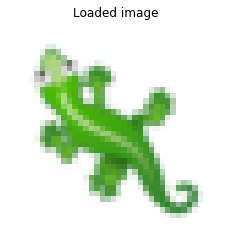

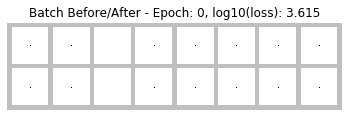

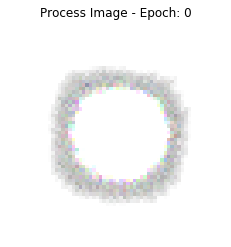

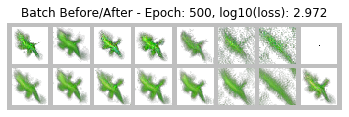

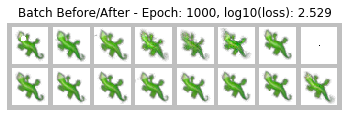

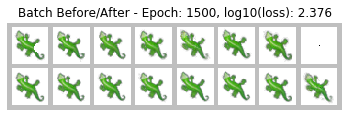

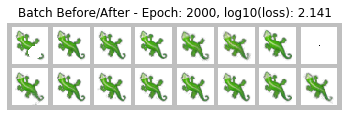

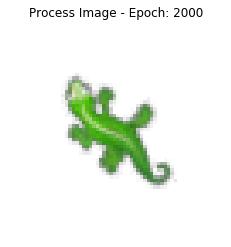

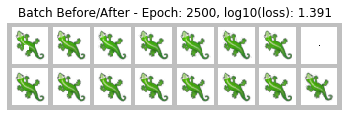

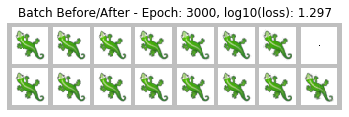

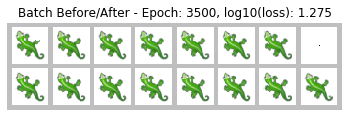

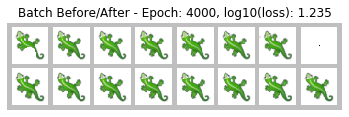

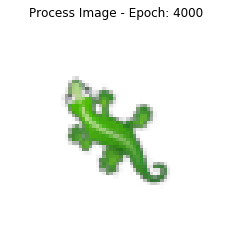

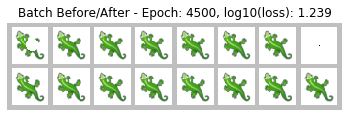

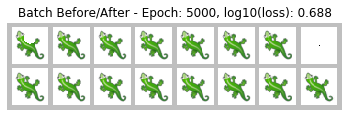

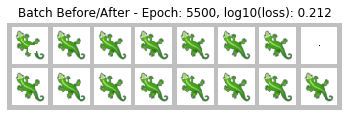

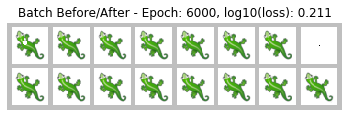

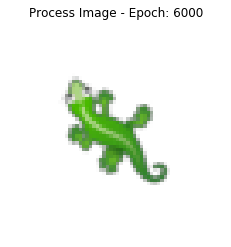

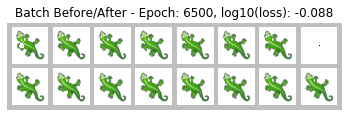

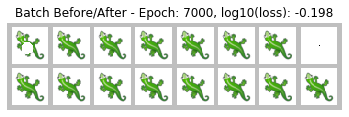

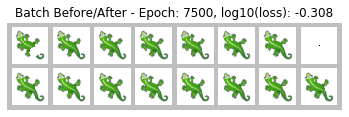

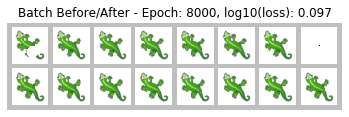

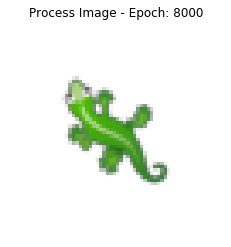

In [4]:
#Training Process

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:",device)

ca = CAModel()
opt = torch.optim.Adam(ca.parameters(),lr=2e-3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=4000, gamma=0.1)
criterion = nn.MSELoss(reduction='sum')

target = load_img("./targets/"+TARGET_IMG_TITLE+".png") #(1, 4, H, W)
h, w = target.shape[2], target.shape[3]
seed = torch.zeros((1,CHANNEL_N,w,h))
seed[:,3:,h//2,w//2] = 1.0

pool = seed.repeat(POOL_SIZE, 1, 1, 1)
ca.to(device)
blank = torch.zeros_like(target).to(device)

epoch_iter = torch.randint(80,100,(EPOCH_N+1,))
for (epoch_i,step_count) in enumerate(epoch_iter):
    with torch.no_grad():
        idx = torch.randperm(POOL_SIZE)[:BATCH_SIZE]
        batch = pool[idx, ...]
        batch_color = to_rgba(batch)
        loss_rank = (batch_color - target.expand_as(batch_color))**2
        loss_rank = loss_rank.mean((1,2,3)).argsort()
        batch = batch[loss_rank, ...]
        damage = 1.0-make_circle_masks(CHANNEL_N, h, w)
        batch[:DAMAGE_N,:,:,:] *= damage
        batch[-REFRESH_N:] = seed
    
    if epoch_i % 100 == 0:
        pre_process_color = to_rgba(batch).clamp(0.0, 1.0)
    
    opt.zero_grad()
    
    batch, target = batch.to(device), target.to(device)
    
    for steps in range(step_count):
        batch = ca(batch)
    
    batch, target = batch.cpu(), target.cpu()
    
    batch_color = to_rgba(batch)
    loss = criterion(batch_color, target.expand_as(batch_color))
    loss.backward()
    for p in ca.parameters():
        p.grad /= (p.grad.norm() + 1e-8)
    opt.step()
    scheduler.step()
    
    pool[idx, ...] = batch
    
    if epoch_i % 500 == 0:
        torch.save(ca.state_dict(), "./tmp_models/"+TARGET_IMG_TITLE+"-epoch-%d.pth"%epoch_i)
        
        post_process_color = batch_color.cpu().clamp(0.0, 1.0)
        process_image = torch.cat([pre_process_color, post_process_color], 0)
        process_image = tv.utils.make_grid(process_image,
                                           padding = 5,
                                           nrow=BATCH_SIZE,
                                           pad_value = 0.5
                                          )
        process_image = TF.to_pil_image(process_image)
        plt.imshow(process_image)
        plt.axis('off')
        plt.title("Batch Before/After - Epoch: %d, log10(loss): %.3f"%(epoch_i, torch.log10(loss).item()))
        plt.show()
    
    if epoch_i % 2000 == 0:
        with torch.no_grad():
            new_x = torch.zeros(1, CHANNEL_N, 64, 64)
            new_x[:,3:,32,32] = 1.0
            new_x = new_x.to(device)
            for steps in range(200):
                new_x = ca(new_x)
            new_x = new_x.cpu()
            result_img = TF.to_pil_image(to_rgba(new_x)[0].clamp(0.0, 1.0))
            plt.imshow(result_img)
            plt.axis('off')
            plt.title("Process Image - Epoch: %d" % epoch_i)
            plt.show()
torch.save(ca.state_dict(), "./final_models/"+TARGET_IMG_TITLE+"-final.pth")

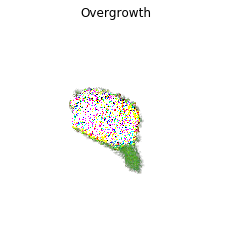

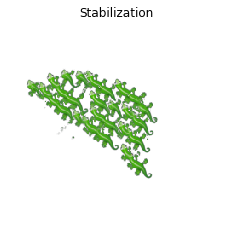

In [5]:
# Experiment

with torch.no_grad():
    ca.to(device)
    new_x = torch.zeros(1, CHANNEL_N, 256, 256)
    new_x[:,3:,128,128] = 1.0
    new_x = new_x.to(device)
    for steps in range(100):
        new_x = ca(new_x, fire_rate=0.75, step_size=1.25)
    new_x = new_x.cpu()
    result_img = TF.to_pil_image(to_rgba(new_x)[0].clamp(0.0, 1.0))
    plt.imshow(result_img)
    plt.axis('off')
    plt.title('Overgrowth')
    plt.show()
    
    new_x = new_x.to(device)
    for steps in range(1000):
        new_x = ca(new_x, fire_rate=0.5)
    new_x = new_x.cpu()
    result_img = TF.to_pil_image(to_rgba(new_x)[0].clamp(0.0, 1.0))
    plt.imshow(result_img)
    plt.axis('off')
    plt.title('Stabilization')
    plt.show()